In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load
df = pd.read_csv('data/full_dataset.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.iloc[1:] # Remove first week

In [3]:
# Format 
df = df.rename(columns={
    'date': 'timestamp',
    'weekly_passenger_volume': 'target'
})

df['item_id'] = 'passenger_volume'

df = df[['item_id', 'timestamp', 'target', 'airport_parking', 'car_rental']]

In [4]:
# ADD KNOWN COVARIATES?

In [5]:
# Splits
test_size = 1
val_size = 4
total_holdout = test_size + val_size

# Create the splits
train_df = df.iloc[:-total_holdout].copy() 
val_df = df.iloc[-total_holdout:-test_size].copy()
test_df = df.iloc[-test_size:].copy()

# Convert to TimeSeriesDataFrame format
train_data = TimeSeriesDataFrame.from_data_frame(
    train_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
val_data = TimeSeriesDataFrame.from_data_frame(
    val_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
test_data = TimeSeriesDataFrame.from_data_frame(
    test_df,
    id_column="item_id",
    timestamp_column="timestamp"
)

In [8]:
# Train
predictor = TimeSeriesPredictor(
    target='target',
    freq='W-SUN',
    prediction_length=test_size,
    path='./autogluon-passenger-model',
    eval_metric='MASE',
    verbosity=2,
    cache_predictions=False
)

predictor.fit(
    train_data,
    tuning_data=val_data,
    presets="high_quality"
)

"""
'RecursiveTabular': {
    'model_name': "TABPFNV2",
},
'DirectTabular': {
    'model_name': "GBM"
},
'TemporalFusionTransformer': {},
'PatchTST': {},
'Chronos': {}
"""


Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Steve\Desktop\flight-tracking\autogluon-passenger-model'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          20
GPU Count:          1
Memory Avail:       16.04 GB / 31.86 GB (50.3%)
Disk Space Avail:   254.53 GB / 1862.21 GB (13.7%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'W-SUN',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Provided train_data has 129 rows, 1 time series. Median time series length is 129 (min=129, m

'\n\'RecursiveTabular\': {\n    \'model_name\': "TABPFNV2",\n},\n\'DirectTabular\': {\n    \'model_name\': "GBM"\n},\n\'TemporalFusionTransformer\': {},\n\'PatchTST\': {},\n\'Chronos\': {}\n'

In [9]:
predictor.evaluate(train_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MASE': -0.07518577798721102}

In [10]:
# Use training and validation data as history to make a prediction for the test set
prediction_data = TimeSeriesDataFrame.from_data_frame(
    pd.concat([train_df, val_df]), 
    id_column="item_id",
    timestamp_column="timestamp"
)
predictions = predictor.predict(prediction_data)

pred_values = (predictions["0.5"].values[0]).round()
actual_values = test_df['target'].values

results_df = pd.DataFrame({
    'timestamp': test_df['timestamp'],
    'actual': actual_values,
    'predicted': pred_values,
    'error': actual_values - pred_values,
    'abs_error': np.abs(actual_values - pred_values),
    'pct_error': np.abs(actual_values - pred_values) / actual_values * 100
})

print("\nPrediction Results:")
print(results_df)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble



Prediction Results:
     timestamp    actual   predicted    error  abs_error  pct_error
134 2025-07-27  19592487  19549068.0  43419.0    43419.0    0.22161


In [11]:
predictor.feature_importance(prediction_data)

Computing feature importance
Subsample_size 50 is larger than the number of items in the data and will be ignored


,importance,stdev,n,p99_low,p99_high
airport_parking,-0.091146,0.0,5.0,-0.091146,-0.091146
car_rental,0.381109,0.0,5.0,0.381109,0.381109


In [13]:
# Convert to average and compare to Kalshi (From last week, ending July 27, Kalshi estimation at 5pm on Tuesday)
actual = (results_df["actual"].values[0] / 7).round()
predicted = (results_df["predicted"].values[0] / 7).round()
kalshi_market_prediction = 2810000
print("actual: ", actual)
print("model error: ", actual - predicted)
print("kalshi error: ", actual - kalshi_market_prediction)

actual:  2798927.0
model error:  6203.0
kalshi error:  -11073.0


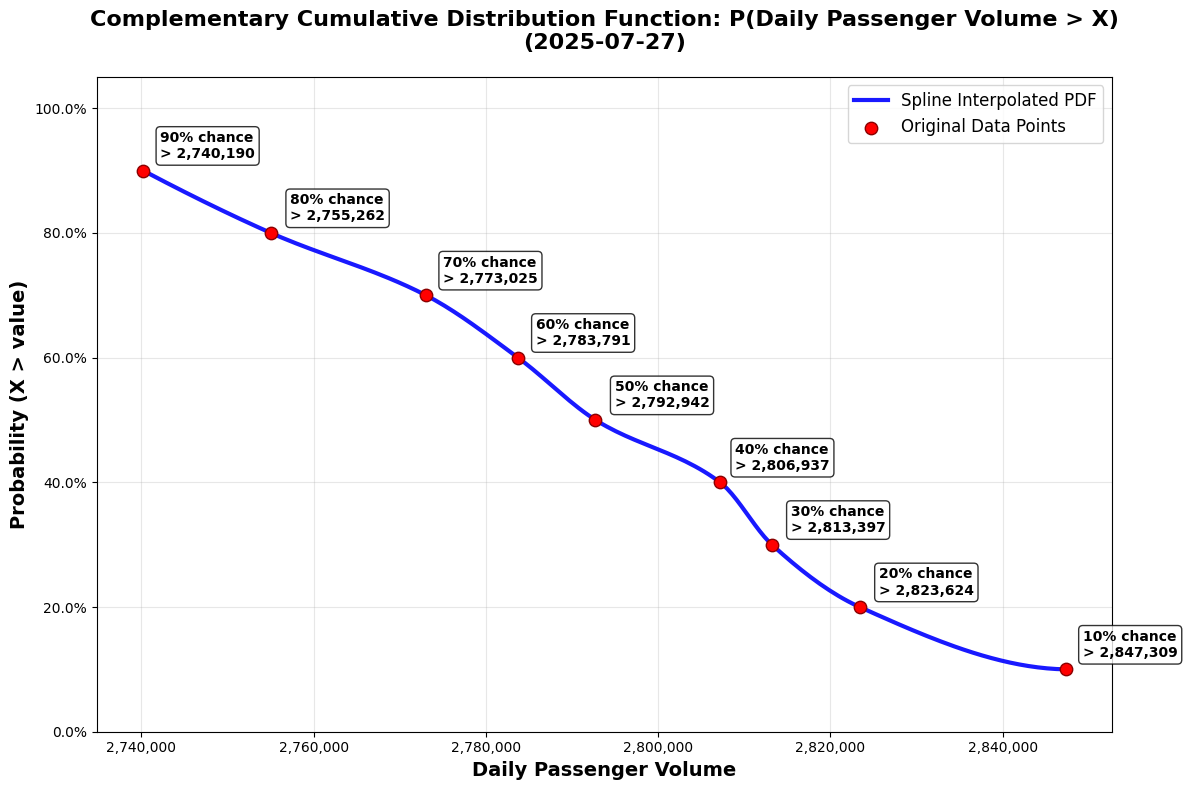

Pointwise estimate:  2792724.0


In [14]:
# Create Complementary Cumulative Distribution Function (probability of passenger volume being greater than a certain number)
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
import numpy as np

def ccdf(predictions):
        # Extract quantile levels and corresponding prediction values
        quantile_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        quantile_columns = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']

        # Get the prediction values for each quantile and convert to daily (divide by 7)
        prediction_values = []
        for col in quantile_columns:
                daily_value = float(predictions[col].iloc[0]) / 7
                prediction_values.append(daily_value)

        # Convert to probability of being greater than that value (survival function)
        # If 10th percentile = X, then P(value > X) = 1 - 0.1 = 0.9
        prob_at_least = [1 - q for q in quantile_levels]

        # Sort by passenger volume for proper interpolation
        sorted_indices = np.argsort(prediction_values)
        sorted_values = [prediction_values[i] for i in sorted_indices]
        sorted_probs = [prob_at_least[i] for i in sorted_indices]

        # Keep range within original data bounds to avoid 0% or 100% probabilities
        min_val, max_val = min(sorted_values), max(sorted_values)
        extended_values = np.linspace(min_val, max_val, 200)

        # Create spline function for probability distribution
        spline_func = PchipInterpolator(sorted_values, sorted_probs)
        spline_probs = spline_func(extended_values)

        # Make sure probabilities stay within [0.1, 0.9] bounds
        spline_probs = np.clip(spline_probs, 0.1, 0.9)


        plt.figure(figsize=(12, 8))

        # Plot the spline-interpolated distribution
        plt.plot(extended_values, spline_probs, 'b-', linewidth=3, 
                label='Spline Interpolated PDF', alpha=0.9)

        # Plot the original quantile points
        plt.scatter(sorted_values, sorted_probs, 
                color='red', s=80, zorder=5, label='Original Data Points', 
                edgecolors='darkred', linewidth=1)

        for prob in quantile_levels:
                # Find the value where probability equals this level
                if prob <= max(sorted_probs) and prob >= min(sorted_probs):
                        idx = np.argmin(np.abs(spline_probs - prob))
                        threshold_value = extended_values[idx]
                        
                        plt.text(threshold_value + 2000, prob + 0.02, 
                                f'{prob*100:.0f}% chance\n> {threshold_value:,.0f}', 
                                color='black', fontweight='bold', fontsize=10,
                                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        # Formatting
        plt.xlabel('Daily Passenger Volume', fontsize=14, fontweight='bold')
        plt.ylabel('Probability (X > value)', fontsize=14, fontweight='bold')
        plt.title(f'Complementary Cumulative Distribution Function: P(Daily Passenger Volume > X)\n({str(predictions.index[0][1])[0:10]})', 
                fontsize=16, fontweight='bold', pad=20)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12, loc='upper right')
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        plt.ylim(0, 1.05)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))

        plt.tight_layout()
        plt.show()

        # Need the spline function created by this to impute custom values
        return spline_func

spline_func = ccdf(predictions);
print("Pointwise estimate: ", (predictions["0.5"].values[0] / 7).round())

In [15]:
target_values = [2750000, 2800000]
kalshi_probs = ['79%', '50%']

print(f"                 Probability Table")
print()
print(f"{'Average Volume':>15} | {'Probability > X':>15} | {'Kalshi Probabilities':>15}")
print(f"{'-'*15} | {'-'*15} | {'-'*15}")

for val, kalshi_prob in zip(target_values, kalshi_probs):
    prob = spline_func(val)
    print(f"{val:>15,} | {prob:>14.1%}  | {kalshi_prob:>15}")

                 Probability Table

 Average Volume | Probability > X | Kalshi Probabilities
--------------- | --------------- | ---------------
      2,750,000 |          83.2%  |             79%
      2,800,000 |          45.3%  |             50%


In [16]:
# Make predictions for this week
prediction_data = TimeSeriesDataFrame.from_data_frame(
    pd.concat([train_df, val_df, test_df]), 
    id_column="item_id",
    timestamp_column="timestamp"
)
predictions = predictor.predict(prediction_data).round()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


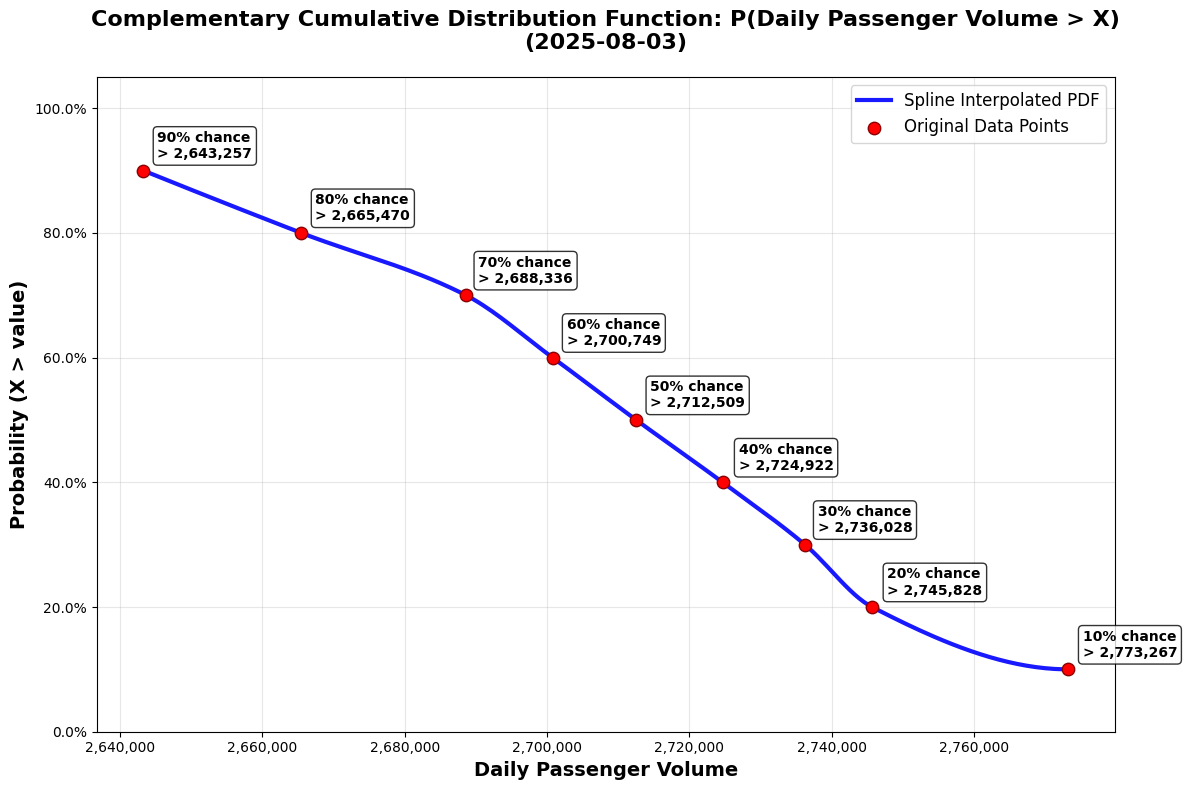

Pointwise estimate:  2712535.285714286


In [17]:
spline_func = ccdf(predictions);
print("Pointwise estimate: ", predictions["0.5"].values[0] / 7)

In [18]:
target_values = [2750000, 2800000]
kalshi_probs = ['72%', '13%']

print(f"                 Probability Table")
print()
print(f"{'Average Volume':>15} | {'Probability > X':>15} | {'Kalshi Probabilities':>15}")
print(f"{'-'*15} | {'-'*15} | {'-'*15}")

for val, kalshi_prob in zip(target_values, kalshi_probs):
    prob = spline_func(val)
    print(f"{val:>15,} | {prob:>14.1%}  | {kalshi_prob:>15}")


                 Probability Table

 Average Volume | Probability > X | Kalshi Probabilities
--------------- | --------------- | ---------------
      2,750,000 |          17.5%  |             72%
      2,800,000 |          26.4%  |             13%
